In [4]:
import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

import matplotlib
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [5]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [6]:
# Фиксируем random_seed (не меняем этот параметр)!
SEED = 42

In [7]:
# Загружаем данные
data = pd.read_csv('train_data.csv')
ans = pd.read_csv('train_ans.csv')
data.shape, ans.shape

((5574703, 3), (57711, 2))

In [8]:
# [1 балл] Разделим данные на обучение и валидацию
# (должно получиться 2 непересекающихся датафрейма)

np.random.seed(SEED)
all_unq_users = np.unique(data.user)
train_users, test_users = np.split(
    np.random.permutation(all_unq_users), [int(len(all_unq_users) * 0.7)]
)

# Ваш код здесь:
train_df = data[data['user'].isin(list(train_users))]
val_df = data[data['user'].isin(list(test_users))]

In [9]:
train_users

array([61983, 25265,  3371, ..., 23760,  9785, 10032])

In [10]:
test_users

array([69530,  5897, 61279, ...,  1228, 22713, 80582])

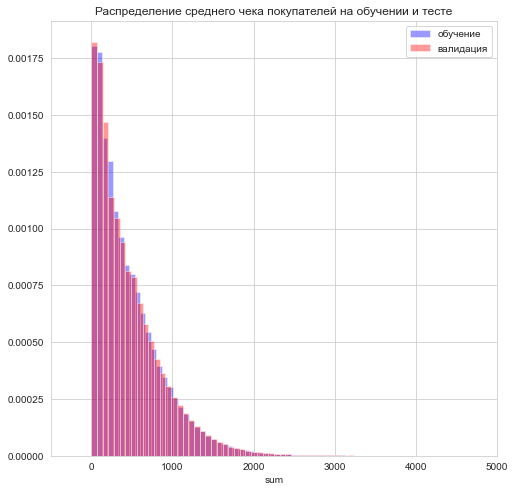

In [11]:
x1 = list(train_df['sum'])
x2 = list(val_df['sum'])

sns.distplot(x1, hist = True, kde = False,  bins = 500, color = 'blue', norm_hist=True, label = 'обучение')
sns.distplot(x2, hist = True, kde = False, bins = 1900, color = 'red', norm_hist=True, label = 'валидация')


plt.xlim(-500, 5000)
plt.xlabel('sum')
plt.title('Распределение среднего чека покупателей на обучении и тесте')
plt.legend(loc = 'upper right')
plt.show()

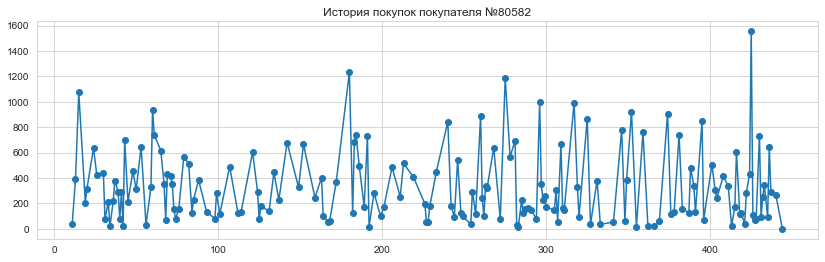

In [12]:
# [1 балл] Изобразите историю сумм покупок для какого-то покупателя
np.random.seed(SEED)
some_user = np.random.choice(all_unq_users)

# Ваш код здесь:
plt.figure(figsize=(14,4))
plt.scatter(data[data['user'] == some_user]['day'], data[data['user'] == some_user]['sum'])
plt.plot(data[data['user'] == some_user]['day'], data[data['user'] == some_user]['sum'])
plt.title('История покупок покупателя №{}'.format(some_user))
plt.show()

In [13]:
# [2 балла] Реализуйте функцию подсчёта мейпа (MAPE)
# Не забудьте учесть случай нулей в y_true

def mape(y_true: np.array, y_pred: np.array) -> float:
    
    """
    Подсчитывает MAPE по формуле: (1/n) * ∑ |y_true - y_pred| / |y_true|
    
    Args:
        y_true: np.array с истинными значениями таргета
        y_pred: np.array с предсказанными значениями
    Returns:
        MAPE (если в y_true есть нули, то такие наблюдения нужно выкинуть из рассчёта метрики)
    """
    
    # Ваш код здесь:
    df = pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
    new_df = df[df['y_true'] != 0]
    y_pred = np.array(new_df.y_pred)
    y_true = np.array(new_df.y_true)
    
    MAPE = (1/(len(y_true))) * (sum(abs(y_true - y_pred)/abs(y_true)))
    
    return MAPE

In [14]:
# [2 балла] Сделайте прогноз как среднюю стоимость покупки на истории и посчитайте его точность (MAPE) 
# (на обучении и на валидации)

# Ваш код здесь: для совокпной таблицы (добавил train_df к val_df снизу, после чего добавил справа к ans) 
X1 = val_df[val_df['sum'] != -1].groupby('user', as_index=False).agg({'sum':'mean'}).rename(columns={'sum': 'mean'})
X2 = train_df[train_df['sum'] != -1].groupby('user', as_index=False).agg({'sum':'mean'}).rename(columns={'sum': 'mean'})
X = X1.append(X2)
X.sort_values(by=['user'], inplace = True)
result = pd.merge(X, ans).rename(columns={'sum':'y_true', 'mean':'y_pred'})
mape(np.array(result['y_true']), np.array(result['y_pred']))

2.0529115715719675

In [15]:
%%time

df = data.pivot(index = 'user', columns='day', values = 'day')

col = []
for i in data.pivot(index = 'user', columns='day', values = 'day').columns:
    col.append('day{}'.format(i-1))
    
col = col[::-1]   
df2 = df.set_axis(col, axis=1, inplace=False)

new_df = data.pivot(index = 'user', columns='day', values = 'sum')

sum_d = []
for i in data.pivot(index = 'user', columns='day', values = 'day').columns:
    sum_d.append('sum{}'.format(i-1))
    
sum_d = sum_d[::-1]
df3 = new_df.set_axis(sum_d, axis=1, inplace=False)

result = pd.merge(df2, df3, on='user')


example = result.iloc[:,:444]
new_col = example.columns[::-1]
example = example[new_col]

#a little bit different result

def repl(input_list):
    L = list(np.array(input_list))
    new_L = [x for x in L if math.isnan(x) == False]
    length_list = len(input_list)
    length_new_L = len(new_L)
    for i in range(length_list - length_new_L):
        new_L.append(0)
    new_L = np.array(new_L)
    return pd.Series(new_L)


def repl2(input_list):
    number = 0
    L = list(np.array(input_list))
    counter = 0
    while math.isnan(L[counter]) == True:
        counter += 1
    new_L = np.array(L[counter:])    
    return pd.Series(new_L)

df_1 = example.apply(repl, axis = 1)
df_1.set_axis(new_col, axis = 1, inplace=True)
df_1.reset_index(inplace=True)
df_1 = df_1.merge(ans, left_on='user', right_on='user').rename(columns={'sum':'target'})

sum_df = result.iloc[:,444:]
sum_df = sum_df.transpose()[::-1].transpose()
sum_df_1 = sum_df.apply(repl, axis = 1)
sum_df_1 = sum_df_1.reset_index()
sum_df_1.drop(columns=0, inplace=True)
sum_df_1.set_axis(sum_d[::-1], axis=1, inplace=True)
sum_df_1.rename(columns={'sum0':'user'}, inplace=True)

final = df_1.merge(sum_df_1, left_on='user', right_on='user')

CPU times: user 47 s, sys: 2.02 s, total: 49 s
Wall time: 49.2 s


In [16]:
%%time
# [3 балла] Напишите функцию, которая переводит данные о продажах (такие как в data) в формат, удобный для модели, 
# а именно, вот в такой формат:
    #user   day0     day1    day2     day3  ... target    sum1   sum2    sum3  ...
    #0      438      437     435      433         20      555     3       40
    #1      398      438     437      315         93      104     409     143
    #...
# (числа в примере рандомные). day0 - день, на который нужно предсказать
    

def prepare_X(df: pd.DataFrame, ans: pd.DataFrame=None) -> pd.DataFrame:
    
    """
    Преобразует данные об истории продаж в удобный для модели формат. 
    Обязательно наличие у df колонок "user", "day" и "sum"
    
    Args:
        df - датафрейм с историей продаж
        ans - датафрейм с таргетами (обязательны колонки "user" и "sum"). Если ans не None, то в выходном
            датафрейме должен быть столбец target
    """
    
    # Ваш код здесь:

    df = df.pivot(index = 'user', columns='day', values = 'day')

    col = []
    for i in df.pivot(index = 'user', columns='day', values = 'day').columns:
        col.append('day{}'.format(i-1))

    col = col[::-1]   
    df2 = df.set_axis(col, axis=1, inplace=False)

    new_df = df.pivot(index = 'user', columns='day', values = 'sum')

    sum_d = []
    for i in df.pivot(index = 'user', columns='day', values = 'day').columns:
        sum_d.append('sum{}'.format(i-1))

    sum_d = sum_d[::-1]
    df3 = new_df.set_axis(sum_d, axis=1, inplace=False)

    result = pd.merge(df2, df3, on='user')


    example = result.iloc[:,:444]
    new_col = example.columns[::-1]
    example = example[new_col]

    #a little bit different result

    def repl(input_list):
        L = list(np.array(input_list))
        new_L = [x for x in L if math.isnan(x) == False]
        length_list = len(input_list)
        length_new_L = len(new_L)
        for i in range(length_list - length_new_L):
            new_L.append(0)
        new_L = np.array(new_L)
        return pd.Series(new_L)


    def repl2(input_list):
        number = 0
        L = list(np.array(input_list))
        counter = 0
        while math.isnan(L[counter]) == True:
            counter += 1
        new_L = np.array(L[counter:])    
        return pd.Series(new_L)

    df_1 = example.apply(repl, axis = 1)
    df_1.set_axis(new_col, axis = 1, inplace=True)
    df_1.reset_index(inplace=True)
    df_1 = df_1.merge(ans, left_on='user', right_on='user').rename(columns={'sum':'target'})

    sum_df = result.iloc[:,444:]
    sum_df = sum_df.transpose()[::-1].transpose()
    sum_df_1 = sum_df.apply(repl, axis = 1)
    sum_df_1 = sum_df_1.reset_index()
    sum_df_1.drop(columns=0, inplace=True)
    sum_df_1.set_axis(sum_d[::-1], axis=1, inplace=True)
    sum_df_1.rename(columns={'sum0':'user'}, inplace=True)

    Xy = df_1.merge(sum_df_1, left_on='user', right_on='user')
    
    return Xy

# Xy = prepare_X(df=data, ans=ans)
# так и не смог понять, почему ругается если выполнить функцию, поэтому оставил просто кодом, который корректно компилирует

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [17]:
%%time
# [1 балл] подберите оптимальное (критерий: MAPE) число соседей на валидации для метода KNN, где в качестве прогноза будем брать
# средние траты по k последним дням, в которых были покупки

#посчитаем сколько вообще максимально может быть соседей, то есть у кого самая длинная  история покупок
final_train = final[final['user'].isin(list(train_users))]
final_test = final[final['user'].isin(list(test_users))]

df = (final_test.iloc[:,446:] != 0)
max_k = df.apply(np.sum, axis = 1).max()

n_neighbours = list(range(2,max_k))
mapes_train = []
mapes_test = []

# Ваш код здесь:


for i in n_neighbours:
    y_pred = np.array(np.mean(final_train.iloc[:,446:446+i], axis=1))
    mapes_train.append(mape(np.array(final_train.loc[:,'target']), y_pred))

for i in n_neighbours:
    y_pred = np.array(np.mean(final_test.iloc[:,446:446+i], axis=1))
    mapes_test.append(mape(np.array(final_test.loc[:,'target']), y_pred))
    
    
# в будущем понадобится сравнивать энкодинги, поэтому сделаю дополнительныей датафрейм для сбора статистики
y_pred_train = np.array(np.mean(final_train.iloc[:,446:446+max_k], axis=1))
mape_no_encoding_train = mape(np.array(final_train.loc[:,'target']), y_pred_train)

y_pred_test = np.array(np.mean(final_test.iloc[:,446:446+max_k], axis=1))
mape_no_encoding_test = mape(np.array(final_test.loc[:,'target']), y_pred_test)

mape_no_encoding = {'mape_train':[mape_no_encoding_train], 'mape_test':[mape_no_encoding_test]}
df_mape = pd.DataFrame(mape_no_encoding, columns=['mape_train', 'mape_test'])
df_mape.index = ['no_encoding']



n_neighbours = np.array(n_neighbours)
mapes_train = np.array(mapes_train)
mapes_test = np.array(mapes_test)

CPU times: user 9.93 s, sys: 983 ms, total: 10.9 s
Wall time: 11 s


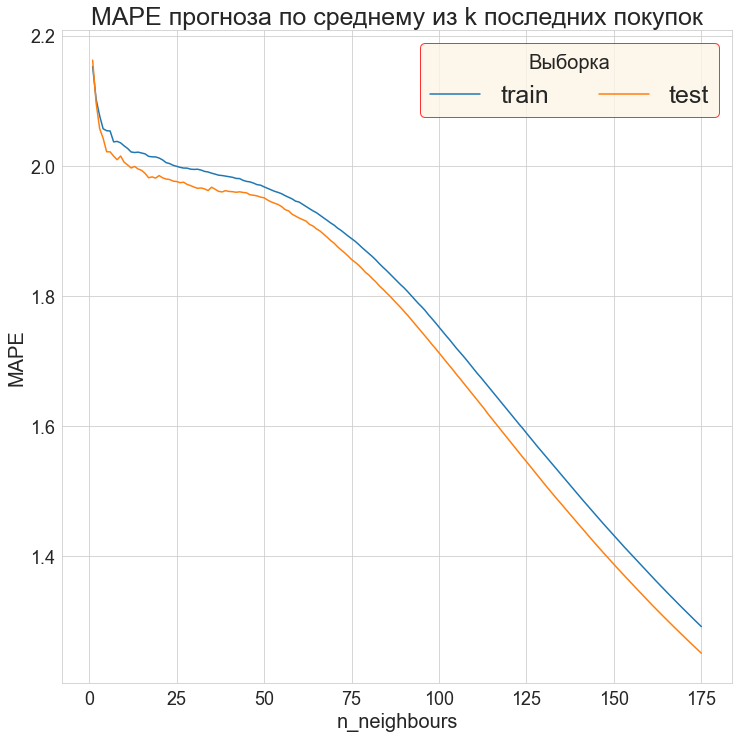

In [18]:
# [1 балл] Изобразите зависимость mapes_train от n_neighbours и mapes_test от n_neighbours

# Ваш код здесь:


fig, ax = plt.subplots()

ax.plot(range(1,max_k-1), mapes_train, label = 'train')
ax.plot(range(1,max_k-1), mapes_test, label = 'test')
plt.xlabel('n_neighbours', fontsize=20)
plt.ylabel('MAPE', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.legend(fontsize = 25,
          ncol = 2,    #  количество столбцов
          facecolor = 'oldlace',    #  цвет области
          edgecolor = 'r',    #  цвет крайней линии
          title = 'Выборка',    #  заголовок
          title_fontsize = '20'    #  размер шрифта заголовка
         )

fig.set_figwidth(12)
fig.set_figheight(12)
plt.title('MAPE прогноза по среднему из k последних покупок', fontsize=25)
plt.show()


### Весовые схемы

Реализуем различные весовые схемы:

1) $\tilde{w_{i}} = \left( \frac{d - i + 1}{d}  \right)^\delta, \ i \in \{1, 2, \dots, d   \}, \ \delta \in [0, +\infty)$

2) $\tilde{w_{i}} = \lambda^i, \ \lambda \in (0, 1]$

3) $\tilde{w_{i}} = \frac{1}{i^\gamma}, \ \gamma \in [0, +\infty)$

Итоговые веса должны быть нормированы: $\sum\limits_{i=1}^d w_{i} = 1$. Для этого просто поделим веса на сумму: $w_{i} = \frac{\tilde{w_{i}}}{\sum\limits_{i=1}^d\tilde{w_{i}}}$

In [19]:
# [3 балла] Реализуйте функции создание весов по схемам, описанным выше
# На выходе веса должны уже быть нормированными

def delta_weights(d: int, delta: float=1.0) -> np.array:
    # Ваш код здесь:
    i = np.array(range(1,d+1))
    w = (np.ones(d)+(np.ones(d)-i)/d)**delta
    new_w = w/w.sum()
    return new_w
    

def lamb_weights(d: int, lamb: float=1) -> np.array:
    # Ваш код здесь:
    w = np.array([lamb]*d)**np.array(range(1,d+1))
    new_w = w/w.sum() 
    return new_w 

def gamma_weights(d: int, gamma: float=1) -> np.array:
    # Ваш код здесь:
    w = np.ones(d)/(np.array(range(1,d+1))**gamma)
    new_w = w/w.sum() 
    return new_w

In [20]:
# [1 балл] Подберите оптимальное значение параметра delta для первой весовой схемы. В качестве числа соседей 
# возьмите оптимальное число, найденное ранее
# оптимальным числом соседей является значение 177, как мы убедились ранее (ключевая метрика mape монотонно убывает по
# мере роста n_neighbours и на трейне и на тесте)
opt_k = max_k

delta_list = list(range(20))
mapes_train = []
mapes_test = []

# Ваш код здесь:


for delta in delta_list:
    y_pred = np.sum(np.array(final_train.iloc[:,446:446+opt_k]) * delta_weights(opt_k, delta), axis=1)
    mapes_train.append(mape(np.array(final_train.loc[:,'target']), y_pred))

for delta in delta_list:
    y_pred = np.sum(np.array(final_test.iloc[:,446:446+opt_k]) * delta_weights(opt_k, delta), axis=1)
    mapes_test.append(mape(np.array(final_test.loc[:,'target']), y_pred))
    
    
    

delta_list = np.array(delta_list)
mapes_train = np.array(mapes_train)
mapes_test = np.array(mapes_test)

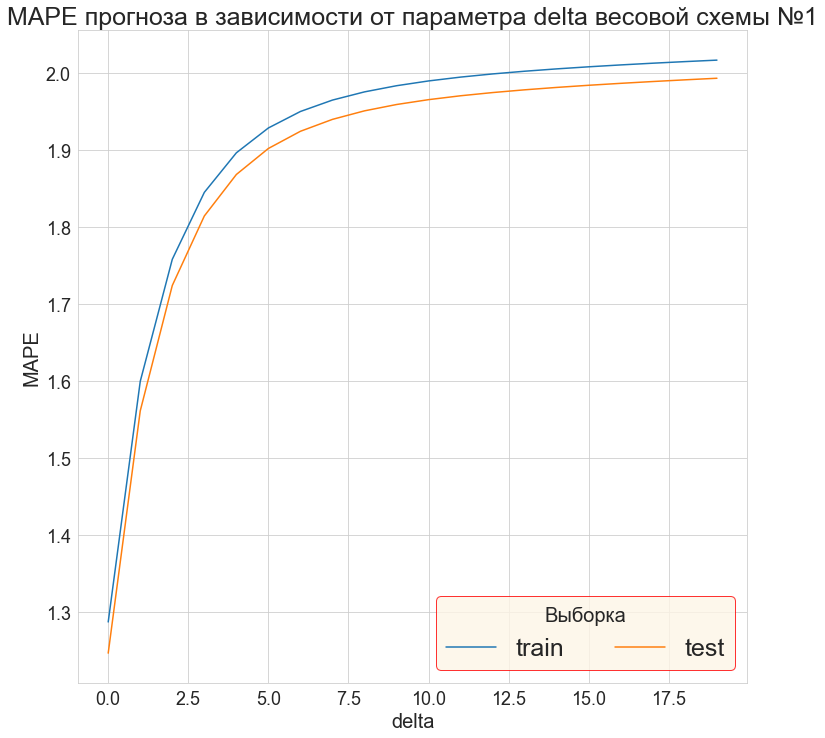

In [21]:
# [1 балл] Изобразите зависимость mapes_train от delta_list и mapes_test от delta_list

# Ваш код здесь:
fig, ax = plt.subplots()

ax.plot(delta_list, mapes_train, label = 'train')
ax.plot(delta_list, mapes_test, label = 'test')
plt.xlabel('delta', fontsize=20)
plt.ylabel('MAPE', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.legend(fontsize = 25,
          ncol = 2,    #  количество столбцов
          facecolor = 'oldlace',    #  цвет области
          edgecolor = 'r',    #  цвет крайней линии
          title = 'Выборка',    #  заголовок
          title_fontsize = '20'    #  размер шрифта заголовка
         )

fig.set_figwidth(12)
fig.set_figheight(12)
plt.title('MAPE прогноза в зависимости от параметра delta весовой схемы №1', fontsize=25)
plt.show()

In [22]:
# [1 балл] Подберите оптимальное значение параметра lamb для второй весовой схемы. В качестве числа соседей 
# возьмите оптимальное число, найденное ранее.
lamba_list = np.linspace(0.1,1,100)
mapes_train = []
mapes_test = []

# Ваш код здесь:


for lamb in lamba_list:
    y_pred = np.sum(np.array(final_train.iloc[:,446:446+opt_k]) * lamb_weights(opt_k, lamb), axis=1)
    mapes_train.append(mape(np.array(final_train.loc[:,'target']), y_pred))

for lamb in lamba_list:
    y_pred = np.sum(np.array(final_test.iloc[:,446:446+opt_k]) * lamb_weights(opt_k, lamb), axis=1)
    mapes_test.append(mape(np.array(final_test.loc[:,'target']), y_pred))
    
    
    

lamba_list = np.array(lamba_list)
mapes_train = np.array(mapes_train)
mapes_test = np.array(mapes_test)

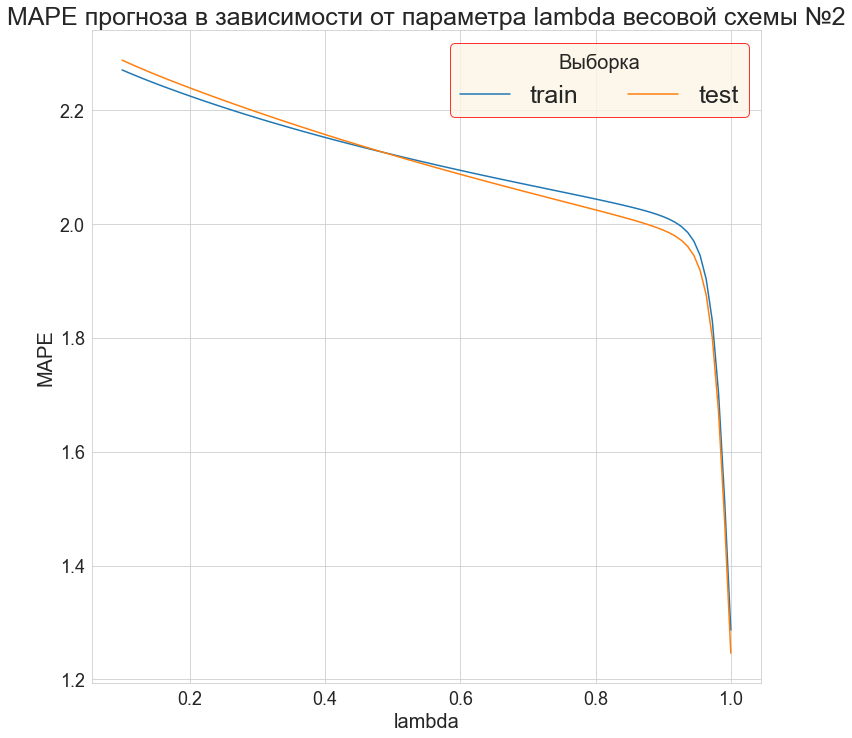

In [23]:
# [1 балл] Изобразите зависимость mapes_train от lamba_list и mapes_test от lamba_list

# Ваш код здесь:
fig, ax = plt.subplots()

ax.plot(lamba_list, mapes_train, label = 'train')
ax.plot(lamba_list, mapes_test, label = 'test')
plt.xlabel('lambda', fontsize=20)
plt.ylabel('MAPE', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.legend(fontsize = 25,
          ncol = 2,    #  количество столбцов
          facecolor = 'oldlace',    #  цвет области
          edgecolor = 'r',    #  цвет крайней линии
          title = 'Выборка',    #  заголовок
          title_fontsize = '20'    #  размер шрифта заголовка
         )

fig.set_figwidth(12)
fig.set_figheight(12)
plt.title('MAPE прогноза в зависимости от параметра lambda весовой схемы №2', fontsize=25)
plt.show()

In [24]:
# [1 балл] Подберите оптимальное значение параметра gamma для третьей весовой схемы. В качестве числа соседей 
# возьмите оптимальное число, найденное ранее.
gamma_list = np.linspace(0,10,40)
mapes_train = []
mapes_test = []

# Ваш код здесь:


for gamma in gamma_list:
    y_pred = np.sum(np.array(final_train.iloc[:,446:446+opt_k]) * gamma_weights(opt_k, gamma), axis=1)
    mapes_train.append(mape(np.array(final_train.loc[:,'target']), y_pred))

for gamma in gamma_list:
    y_pred = np.sum(np.array(final_test.iloc[:,446:446+opt_k]) * gamma_weights(opt_k, gamma), axis=1)
    mapes_test.append(mape(np.array(final_test.loc[:,'target']), y_pred))
    
    
    

gamma_list = np.array(gamma_list)
mapes_train = np.array(mapes_train)
mapes_test = np.array(mapes_test)

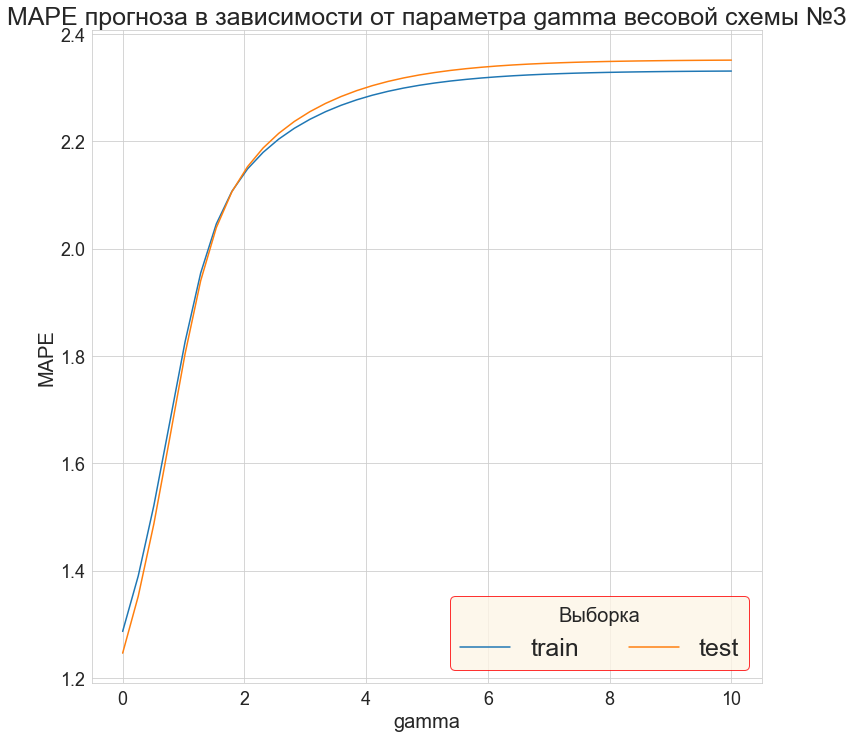

In [25]:
# [1 балл] Изобразите зависимость mapes_train от gamma_list и mapes_test от gamma_list

# Ваш код здесь:
fig, ax = plt.subplots()

ax.plot(gamma_list, mapes_train, label = 'train')
ax.plot(gamma_list, mapes_test, label = 'test')
plt.xlabel('gamma', fontsize=20)
plt.ylabel('MAPE', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.legend(fontsize = 25,
          ncol = 2,    #  количество столбцов
          facecolor = 'oldlace',    #  цвет области
          edgecolor = 'r',    #  цвет крайней линии
          title = 'Выборка',    #  заголовок
          title_fontsize = '20'    #  размер шрифта заголовка
         )
plt.yscale('linear')

fig.set_figwidth(12)
fig.set_figheight(12)
plt.title('MAPE прогноза в зависимости от параметра gamma весовой схемы №3', fontsize=25)
plt.show()

### Дополнительные пункты

<ol>
    <li> [3 Балла]
        Попробуйте добавить признаков в модель (День недели, день месяца, номер месяца, расстояние до какой-то даты, ...). Увеличили ли они качество предсказания для Вашей модели?</li>
    <li> [3 Балла] Попробуйте отнестись к признаком дат как к категориальным и сделать для них энкодинги (label encoding, OHE, target encoding, ...). Какая кодировка приводит к наибольшему качеству?</li>
    <li> [4 Балла] В этом пункте у Вас нет ограничения по методикам и моделям - добейтесь максимального качества (минимальный MAPE) на валидации</li>
</ol>

## Feature engineering

In [26]:
final

,user,day0,day1,day2,day3,day4,day5,day6,day7,day8,...,sum434,sum435,sum436,sum437,sum438,sum439,sum440,sum441,sum442,sum443
0,1,438.0,437.0,433.0,432.0,430.0,423.0,421.0,419.0,417.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,439.0,437.0,435.0,426.0,424.0,419.0,416.0,415.0,412.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,439.0,434.0,432.0,425.0,420.0,412.0,404.0,396.0,391.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,432.0,429.0,426.0,423.0,421.0,419.0,416.0,411.0,409.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,434.0,425.0,421.0,418.0,411.0,394.0,381.0,375.0,372.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57706,82439,440.0,432.0,413.0,410.0,409.0,404.0,397.0,395.0,394.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57707,82440,444.0,438.0,436.0,434.0,431.0,430.0,428.0,426.0,425.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57708,82442,441.0,438.0,437.0,432.0,427.0,425.0,420.0,416.0,415.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57709,82443,440.0,438.0,436.0,435.0,432.0,429.0,428.0,426.0,422.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Add difference between dates neighboring purchases (last 30 differencecs)

In [27]:
final['day0-day1'] = final['day0'] - final['day1']
final['day1-day2'] = final['day1'] - final['day2']
final['day2-day3'] = final['day2'] - final['day3']
final['day3-day4'] = final['day3'] - final['day4']
final['day4-day5'] = final['day4'] - final['day5']
final['day5-day6'] = final['day5'] - final['day6']
final['day6-day7'] = final['day6'] - final['day7']
final['day7-day8'] = final['day7'] - final['day8']
final['day8-day9'] = final['day8'] - final['day9']
final['day9-day10'] = final['day9'] - final['day10']
final['day10-day11'] = final['day10'] - final['day11']
final['day11-day12'] = final['day11'] - final['day12']
final['day12-day13'] = final['day12'] - final['day13']
final['day13-day14'] = final['day13'] - final['day14']
final['day14-day15'] = final['day14'] - final['day15']
final['day15-day16'] = final['day15'] - final['day16']
final['day16-day17'] = final['day16'] - final['day17']
final['day17-day18'] = final['day17'] - final['day18']
final['day18-day19'] = final['day18'] - final['day19']
final['day19-day20'] = final['day19'] - final['day20']
final['day20-day21'] = final['day20'] - final['day21']
final['day21-day22'] = final['day21'] - final['day22']
final['day22-day23'] = final['day22'] - final['day23']
final['day23-day24'] = final['day23'] - final['day24']
final['day24-day25'] = final['day24'] - final['day25']
final['day25-day26'] = final['day25'] - final['day26']
final['day26-day27'] = final['day26'] - final['day27']
final['day27-day28'] = final['day27'] - final['day28']
final['day28-day29'] = final['day28'] - final['day29']
final['day29-day30'] = final['day29'] - final['day30']

#difference in sum of neighbour purchases (last 30 differencecs)
final['sum1-sum2'] = final['sum1'] - final['sum2']
final['sum2-sum3'] = final['sum2'] - final['sum3']
final['sum3-sum4'] = final['sum3'] - final['sum4']
final['sum4-sum5'] = final['sum4'] - final['sum5']
final['sum5-sum6'] = final['sum5'] - final['sum6']
final['sum6-sum7'] = final['sum6'] - final['sum7']
final['sum7-sum8'] = final['sum7'] - final['sum8']
final['sum8-sum9'] = final['sum8'] - final['sum9']
final['sum9-sum10'] = final['sum9'] - final['sum10']
final['sum10-sum11'] = final['sum10'] - final['sum11']
final['sum11-sum12'] = final['sum11'] - final['sum12']
final['sum12-sum13'] = final['sum12'] - final['sum13']
final['sum13-sum14'] = final['sum13'] - final['sum14']
final['sum14-sum15'] = final['sum14'] - final['sum15']
final['sum15-sum16'] = final['sum15'] - final['sum16']
final['sum16-sum17'] = final['sum16'] - final['sum17']
final['sum17-sum18'] = final['sum17'] - final['sum18']
final['sum18-sum19'] = final['sum18'] - final['sum19']
final['sum19-sum20'] = final['sum19'] - final['sum20']
final['sum20-sum21'] = final['sum20'] - final['sum21']
final['sum21-sum22'] = final['sum21'] - final['sum22']
final['sum22-sum23'] = final['sum22'] - final['sum23']
final['sum23-sum24'] = final['sum23'] - final['sum24']
final['sum24-sum25'] = final['sum24'] - final['sum25']
final['sum25-sum26'] = final['sum25'] - final['sum26']
final['sum26-sum27'] = final['sum26'] - final['sum27']
final['sum27-sum28'] = final['sum27'] - final['sum28']
final['sum28-sum29'] = final['sum28'] - final['sum29']
final['sum29-sum30'] = final['sum29'] - final['sum30']
final['sum30-sum31'] = final['sum30'] - final['sum31']

In [28]:
final_train = final[final['user'].isin(list(train_users))]
final_test = final[final['user'].isin(list(test_users))]

In [29]:
final

,user,day0,day1,day2,day3,day4,day5,day6,day7,day8,...,sum21-sum22,sum22-sum23,sum23-sum24,sum24-sum25,sum25-sum26,sum26-sum27,sum27-sum28,sum28-sum29,sum29-sum30,sum30-sum31
0,1,438.0,437.0,433.0,432.0,430.0,423.0,421.0,419.0,417.0,...,577.0,-534.0,599.0,19.0,-195.0,254.0,-755.0,749.0,-509.0,-243.0
1,2,439.0,437.0,435.0,426.0,424.0,419.0,416.0,415.0,412.0,...,-329.0,227.0,-405.0,423.0,-265.0,350.0,9.0,-61.0,49.0,-14.0
2,4,439.0,434.0,432.0,425.0,420.0,412.0,404.0,396.0,391.0,...,18.0,-1096.0,544.0,173.0,464.0,-728.0,264.0,-50.0,516.0,-493.0
3,5,432.0,429.0,426.0,423.0,421.0,419.0,416.0,411.0,409.0,...,513.0,-93.0,-1267.0,1167.0,21.0,-880.0,-224.0,789.0,151.0,264.0
4,7,434.0,425.0,421.0,418.0,411.0,394.0,381.0,375.0,372.0,...,456.0,-257.0,899.0,-871.0,123.0,-95.0,-54.0,347.0,-273.0,-141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57706,82439,440.0,432.0,413.0,410.0,409.0,404.0,397.0,395.0,394.0,...,1519.0,3.0,-191.0,124.0,-616.0,219.0,444.0,-183.0,175.0,-3.0
57707,82440,444.0,438.0,436.0,434.0,431.0,430.0,428.0,426.0,425.0,...,-270.0,303.0,-491.0,67.0,-39.0,261.0,177.0,-350.0,364.0,-407.0
57708,82442,441.0,438.0,437.0,432.0,427.0,425.0,420.0,416.0,415.0,...,-34.0,-827.0,-87.0,770.0,-461.0,244.0,274.0,-602.0,774.0,-43.0
57709,82443,440.0,438.0,436.0,435.0,432.0,429.0,428.0,426.0,422.0,...,592.0,146.0,-1038.0,838.0,190.0,-62.0,-566.0,-120.0,734.0,26.0


# Adding encodings to day

## Label encoding

In [30]:
# Загружаем данные
data = pd.read_csv('train_data.csv')
ans = pd.read_csv('train_ans.csv')
data.shape, ans.shape

((5574703, 3), (57711, 2))

In [31]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
data['day'] = lb_make.fit_transform(data['day'])
# Очевидно в таком случае качество моджели не изменится так как label encoding всего навсего каждое значение дня снижает на единицу, 
# поэтому метрики качества не должны поменяться

In [32]:
df = data.pivot(index = 'user', columns='day', values = 'day')

col = []
for i in data.pivot(index = 'user', columns='day', values = 'day').columns:
    col.append('day{}'.format(i-1))
    
col = col[::-1]   
df2 = df.set_axis(col, axis=1, inplace=False)

new_df = data.pivot(index = 'user', columns='day', values = 'sum')

sum_d = []
for i in data.pivot(index = 'user', columns='day', values = 'day').columns:
    sum_d.append('sum{}'.format(i-1))
    
sum_d = sum_d[::-1]
df3 = new_df.set_axis(sum_d, axis=1, inplace=False)

result = pd.merge(df2, df3, on='user')


example = result.iloc[:,:444]
new_col = example.columns[::-1]
example = example[new_col]

#a little bit different result

def repl(input_list):
    L = list(np.array(input_list))
    new_L = [x for x in L if math.isnan(x) == False]
    length_list = len(input_list)
    length_new_L = len(new_L)
    for i in range(length_list - length_new_L):
        new_L.append(0)
    new_L = np.array(new_L)
    return pd.Series(new_L)


def repl2(input_list):
    number = 0
    L = list(np.array(input_list))
    counter = 0
    while math.isnan(L[counter]) == True:
        counter += 1
    new_L = np.array(L[counter:])    
    return pd.Series(new_L)

df_1 = example.apply(repl, axis = 1)
df_1.set_axis(new_col, axis = 1, inplace=True)
df_1.reset_index(inplace=True)
df_1 = df_1.merge(ans, left_on='user', right_on='user').rename(columns={'sum':'target'})

sum_df = result.iloc[:,444:]
sum_df = sum_df.transpose()[::-1].transpose()
sum_df_1 = sum_df.apply(repl, axis = 1)
sum_df_1 = sum_df_1.reset_index()
sum_df_1.drop(columns=0, inplace=True)
sum_df_1.set_axis(sum_d[::-1], axis=1, inplace=True)
sum_df_1.rename(columns={'sum0':'user'}, inplace=True)

final = df_1.merge(sum_df_1, left_on='user', right_on='user')

In [33]:
final_train = final[final['user'].isin(list(train_users))]
final_test = final[final['user'].isin(list(test_users))]

df = (final_test.iloc[:,446:] != 0)
max_k = df.apply(np.sum, axis = 1).max()

y_pred_train = np.array(np.mean(final_train.iloc[:,446:446+max_k], axis=1))
mape_lable_encoding_train = mape(np.array(final_train.loc[:,'target']), y_pred_train)

y_pred_test = np.array(np.mean(final_test.iloc[:,446:446+max_k], axis=1))
mape_lable_encoding_test = mape(np.array(final_test.loc[:,'target']), y_pred_test)

mape_lable_encoding = {'mape_train':[mape_lable_encoding_train], 'mape_test':[mape_lable_encoding_test]}

df_mape_1 = pd.DataFrame(mape_lable_encoding, columns=['mape_train', 'mape_test'])
df_mape_1.index = ['lable_encoding']
# Гипотеза о том, что никакой разницы в терминах изменения метрики mape нет при добавления label encoding для дня
df_mape = df_mape.append(df_mape_1)

In [34]:
df_mape

,mape_train,mape_test
no_encoding,1.286744,1.246207
lable_encoding,2.946951,1.889765


## Target encoding

In [35]:
# Загружаем данные
data = pd.read_csv('train_data.csv')
ans = pd.read_csv('train_ans.csv')
data.shape, ans.shape

((5574703, 3), (57711, 2))

In [36]:
from category_encoders import TargetEncoder

In [37]:
encoder = TargetEncoder()

In [38]:
data

,user,day,sum
0,1,3,1146
1,1,5,71
2,1,6,65
3,1,10,63
4,1,12,31
...,...,...,...
5574698,82444,429,150
5574699,82444,432,500
5574700,82444,434,988
5574701,82444,443,973


#### Я считаю, что в данной постановке задачи нет никакого чмысла использовать target encoding так как если мы заменим наш категориальный признак дат на target признак sum, то мы потерям в информации так как избавимся от важного регрессора истории, поэтому на фундоментальном уровне нет причин считать, что Target encoding приведёт к лучшему результату по сравнению с Label encoding например

### OHE

In [39]:
# смысла в данном случае, по-моему, нет использовать ohe так как кодирование дат уберёт отношение порядка которое заложено
# номерами дней (которое мы произвели до момента покупки). Поэтому согласно данной интеерпретации я считаю, что не имеет смысла 
# избавляться от порядковой информации вводя ohe, поэтому я не буду этого делать

In [40]:
from sklearn.preprocessing import OneHotEncoder

In [41]:
encoder = OneHotEncoder(categories = 'auto')

In [42]:
X = encoder.fit_transform(
    data['day'].values.reshape(-1,1)).toarray()
dfonehot = pd.DataFrame(X)
data = pd.concat([data, dfonehot], axis =1)

In [43]:
data.drop(columns=['day'], inplace=True)

In [44]:
data

,user,sum,0,1,2,3,4,5,6,7,...,434,435,436,437,438,439,440,441,442,443
0,1,1146,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,71,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,65,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5574698,82444,150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5574699,82444,500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5574700,82444,988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5574701,82444,973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Имея теперь такое представление я не представляю как интегрировать такой dataframe в моё решение (гдепроисохит перевод таблицы в удобный вид) поэтому остановлюсь на этому шаге, я считаю, что рассуждая на фундаметнальном уровне, дни имеют порядок, а ohe убирает любое отношение порядка, таким образом убирает часть информации для нас, значит стоит отдать предпочтение, например label encoding, у которого нет такого недостатка

## Итог: Я считаю, что самым лучшим является Label Encoding

# Потсроение разных моделей

In [45]:
y, X = final['target'], final.drop(columns=['target'])

### Train test split

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [62]:
import random
random.seed(42)

### KNN

In [48]:
from sklearn.neighbors import KNeighborsRegressor

In [63]:
knn_reg = KNeighborsRegressor(n_neighbors=4, algorithm = 'auto')

In [64]:
%%time
knn_reg.fit(X_train, y_train)
y_predict = knn_reg.predict(X_test)

CPU times: user 1min 31s, sys: 125 ms, total: 1min 31s
Wall time: 1min 31s


In [65]:
mape(y_test, y_predict)

2.5362871910079012

In [52]:
from sklearn.model_selection import RandomizedSearchCV

In [53]:
KNeighborsRegressor()

KNeighborsRegressor()

In [66]:
%%time
knn = KNeighborsRegressor()

params = dict(n_neighbors = [2,4,6], algorithm=['brute', 'kd_tree', 'auto'])

CPU times: user 26 µs, sys: 1e+03 ns, total: 27 µs
Wall time: 29.1 µs


In [67]:
%%time
rs_reg = RandomizedSearchCV(estimator=knn, param_distributions=params,n_iter = 2, cv = 2, random_state=42 , n_jobs = -1)
search = rs_reg.fit(X_train, y_train)
search.best_params_

CPU times: user 2.68 s, sys: 466 ms, total: 3.15 s
Wall time: 58.6 s


{'n_neighbors': 4, 'algorithm': 'auto'}

In [68]:
y_predict_1 = search.predict(X_test)

In [69]:
mape(y_test, y_predict_1)

2.5362871910079012

### Random Forest

In [233]:
from sklearn.ensemble import RandomForestRegressor

In [253]:
rf = RandomForestRegressor()

In [254]:
params = dict(n_estimators = [50,100,200], max_depth=[3,5,7])

In [255]:
%%time
rs_rf = RandomizedSearchCV(estimator=rf, param_distributions=params, cv = 2, random_state=42)
search_rf = rs_rf.fit(X_train, y_train)
search_rf.best_params_

CPU times: user 38min 11s, sys: 4 s, total: 38min 14s
Wall time: 38min 18s


{'n_estimators': 100, 'max_depth': 7}

In [258]:
y_predict_rf = search_rf.best_estimator_.predict(X_test)

In [259]:
mape(y_test, y_predict_rf)

2.064651600310861

### SVM

In [266]:
from sklearn.svm import SVR

In [267]:
svm = SVR()

In [268]:
reg_svm = svm.fit(X_train, y_train)

In [281]:
# считается минут 20-30

In [269]:
y_predict_svm = reg_svm.predict(X_test)
mape(y_test, y_predict_svm)

1.9357023899297836

### LASSO

In [83]:
from sklearn.linear_model import LassoCV

In [84]:
%%time
lasso = LassoCV()
lasso.fit(X_train, y_train)

CPU times: user 2min 13s, sys: 3.28 s, total: 2min 17s
Wall time: 22 s


LassoCV()

In [85]:
y_predict_lasso = lasso.predict(X_test)
lasso_mape = mape(y_test, y_predict_lasso)
lasso_mape

2.14832192873217

### Ridge Regression

In [59]:
from sklearn.linear_model import RidgeCV

In [60]:
%%time
ridge = RidgeCV()
ridge.fit(X_train, y_train)

CPU times: user 12 s, sys: 640 ms, total: 12.6 s
Wall time: 2.32 s


RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [61]:
y_predict_ridge = ridge.predict(X_test)
ridge_mape = mape(y_test, y_predict_ridge)
ridge_mape

1.90082872771356

In [70]:
from sklearn.model_selection import GridSearchCV

In [73]:
ridge.get_params().keys()

dict_keys(['alphas', 'cv', 'fit_intercept', 'gcv_mode', 'normalize', 'scoring', 'store_cv_values'])

In [81]:
%%time
params_Ridge = {"fit_intercept": [True, False]}
Ridge_GS = GridSearchCV(ridge, param_grid=params_Ridge)
Ridge_GS.fit(X_train,y_train)
Ridge_GS.best_params_

CPU times: user 2min, sys: 3.84 s, total: 2min 4s
Wall time: 17.8 s


{'fit_intercept': True}

In [82]:
y_predict_ridge_cv = Ridge_GS.best_estimator_.predict(X_test)
ridge_mape_cv = mape(y_test, y_predict_ridge_cv)
ridge_mape_cv

1.90082872771356

### ElasticNet Regression

In [87]:
from sklearn.linear_model import ElasticNetCV

In [88]:
%%time
en = ElasticNetCV()
en.fit(X_train, y_train)

CPU times: user 2min 1s, sys: 2.91 s, total: 2min 3s
Wall time: 20.3 s


ElasticNetCV()

In [89]:
y_predict_en = en.predict(X_test)
en_mape = mape(y_test, y_predict_en)
en_mape

2.233143071328996

In [90]:
regression_algorithms_results = pd.DataFrame({'mape':[2.536, 2.065, 1.936, 2.148, 1.901, 2.233]}, columns = ['mape'], 
                                             index=['KNN','Random Forest','SVM','Lasso', 'Ridge Regression', 'Elastic Net'])

In [91]:
regression_algorithms_results

,mape
KNN,2.536
Random Forest,2.065
SVM,1.936
Lasso,2.148
Ridge Regression,1.901
Elastic Net,2.233


### Получение предсказаний для теста

In [92]:
%%time
# Загружаем данные, для которых хотим получить предсказания
test_data = pd.read_csv('test_data.csv')

CPU times: user 364 ms, sys: 61.7 ms, total: 426 ms
Wall time: 428 ms


In [99]:
%%time
# [1 балл] Получите предсказания для test_data (лучшей из моделей, которые Вы получили ранее) 
# и сохраните их в файл "test_predictions.csv" в той же папке.

# Ваш код здесь:
data = test_data

df = data.pivot(index = 'user', columns='day', values = 'day')

col = []
for i in data.pivot(index = 'user', columns='day', values = 'day').columns:
    col.append('day{}'.format(i-1))
    
col = col[::-1]   
df2 = df.set_axis(col, axis=1, inplace=False)

new_df = data.pivot(index = 'user', columns='day', values = 'sum')

sum_d = []
for i in data.pivot(index = 'user', columns='day', values = 'day').columns:
    sum_d.append('sum{}'.format(i-1))
    
sum_d = sum_d[::-1]
df3 = new_df.set_axis(sum_d, axis=1, inplace=False)

result = pd.merge(df2, df3, on='user')
example = result.iloc[:,:444]
new_col = example.columns[::-1]
example = example[new_col]

#a little bit different result

def repl(input_list):
    L = list(np.array(input_list))
    new_L = [x for x in L if math.isnan(x) == False]
    length_list = len(input_list)
    length_new_L = len(new_L)
    for i in range(length_list - length_new_L):
        new_L.append(0)
    new_L = np.array(new_L)
    return pd.Series(new_L)


def repl2(input_list):
    number = 0
    L = list(np.array(input_list))
    counter = 0
    while math.isnan(L[counter]) == True:
        counter += 1
    new_L = np.array(L[counter:])    
    return pd.Series(new_L)

df_1 = example.apply(repl, axis = 1)
df_1.set_axis(new_col, axis = 1, inplace=True)
df_1.reset_index(inplace=True)

sum_df = result.iloc[:,444:]
sum_df = sum_df.transpose()[::-1].transpose()
sum_df_1 = sum_df.apply(repl, axis = 1)
sum_df_1 = sum_df_1.reset_index()
sum_df_1.drop(columns=0, inplace=True)
sum_df_1.set_axis(sum_d[::-1], axis=1, inplace=True)
sum_df_1.rename(columns={'sum0':'user'}, inplace=True)

absolute_final = df_1.merge(sum_df_1, left_on='user', right_on='user')
my_prediction = Ridge_GS.best_estimator_.predict(absolute_final)
np.savetxt("test_predictions.csv", my_prediction, delimiter=",")

CPU times: user 19.9 s, sys: 1.14 s, total: 21 s
Wall time: 20.6 s
